In [1]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
from scipy.stats import skewnorm
# from ll_xy import lonlat_to_xy
from scipy.stats import linregress
import datetime
import string
import cartopy
import tools
import cartopy.crs as ccrs
import pandas as pd
from dateutil.relativedelta import relativedelta
pd.set_option("mode.chained_assignment", None)

dep_l = pickle.load(open('../pickles/line_depths_dict.p','rb'))
statistics = pickle.load(open('../pickles/statistics.p','rb'))

In [2]:
name = 'Tuk'
# name = 'Atlanta'

def get_df_dates(name):

    df = pd.read_excel('../evaluation_data/SHEBA_transects/SHEBAsnowNCAR.xls',sheet_name=name,skiprows=6)

    dates = [d for d in df.columns if type(d) == datetime.datetime]

    df = pd.read_excel('../evaluation_data/SHEBA_transects/SHEBAsnowNCAR.xls',sheet_name=name,skiprows=12)

    df = df.replace(['mp','fmp'], 'nan')
    
    return (df, dates)

In [3]:
def compute_rmse_depth(df,season='all'):

    bw = 5
    
    bin_edges = np.arange(0,81,bw)

    mean_magna = np.nanmean(df['DepthCm'])

    bc, ft = tools.depth_distribution_from_depth(mean_magna,bin_edges,statistics=statistics['all'])

    hist, bin_edges = np.histogram(df['DepthCm'],bins=bin_edges, density=True)
    
    rmse = np.sqrt(np.mean(np.square(ft-(hist*bw))))
    
    return (rmse,mean_magna)

In [4]:
statistics['all']

{'a': 2.542562886886376,
 'loc': -1.114525560819975,
 'scale': 1.4973819434202296,
 'CV': 0.41696167189340216,
 'n': 33539}

/tmp/ipykernel_226050/2580355744.py:63: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  magna_stats = np.linalg.lstsq(np.array(means)[:,np.newaxis],stds)
/tmp/ipykernel_226050/2580355744.py:67: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  safe_magna_stats = np.linalg.lstsq(np.array(safe_means)[:,np.newaxis],safe_stds)


2.9429869031722244 -1.1184674472909342 1.500303497280723


/tmp/ipykernel_226050/2580355744.py:63: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  magna_stats = np.linalg.lstsq(np.array(means)[:,np.newaxis],stds)
/tmp/ipykernel_226050/2580355744.py:67: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  safe_magna_stats = np.linalg.lstsq(np.array(safe_means)[:,np.newaxis],safe_stds)


6.267488371641327 -1.0810899558419755 1.4726709607978101


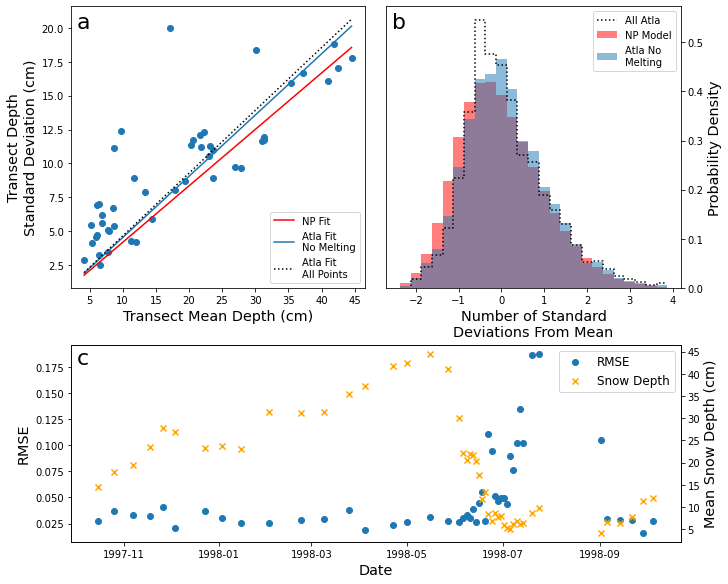

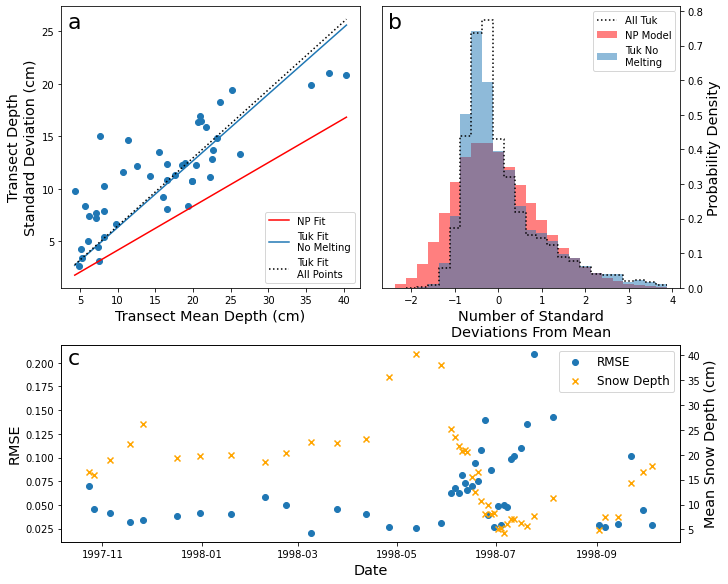

In [20]:
name = 'Atlanta'
name = 'Tuk'

def make_figure(name):
    df, dates = get_df_dates(name)

    nas = []
    full_depths = []
    stds = []
    means = []

    safe_nas = []
    safe_means = []
    safe_stds = []

    real_cols = [col for col in df if 'cm' in col]

    for column, date in zip(real_cols, dates):

        depths = df[column]

        clean_depths = np.array([abs(d) for d in depths if (str(d) != 'nan') & (str(d) != ' ')])[::1].astype(float)


        mean_depth = np.mean(clean_depths)
        std_depth = np.std(clean_depths)

        anoms = clean_depths - mean_depth

        normed_anoms = anoms/std_depth

        nas.append(list(normed_anoms))

        if date.month not in [7]:
            safe_nas.append(list(normed_anoms))
            safe_stds.append(std_depth)
            safe_means.append(mean_depth)

        stds.append(std_depth)
        means.append(mean_depth)


        if mean_depth < 0: print(clean_depths)

        full_depths.append({'DepthCm':clean_depths,
                            'date':date})

    #######################################################

    bw = 0.25

    bin_edges = np.arange(-2.5,4,bw)

    bin_centres = bin_edges[1:]

    season = 'all'

    fit = skewnorm.pdf(bin_centres,
                       statistics[season]['a'],
                       statistics[season]['loc'],
                       statistics[season]['scale'])

    magna_stats = np.linalg.lstsq(np.array(means)[:,np.newaxis],stds)

    magna_linear_prediction = np.array([np.min(means),np.max(means)])*magna_stats[0][0]

    safe_magna_stats = np.linalg.lstsq(np.array(safe_means)[:,np.newaxis],safe_stds)

    safe_magna_linear_prediction = np.array([np.min(means),np.max(means)])*safe_magna_stats[0][0]

    linear_prediction = np.array([np.min(means),np.max(means)])*statistics['all']['CV']

    vals, bin_edges = np.histogram(np.concatenate(nas),bins=bin_edges,density=True)

    safe_vals, bin_edges = np.histogram(np.concatenate(safe_nas),bins=bin_edges,density=True)

    ###

    rmses = []
    mean_deps = []
    for depths in full_depths:
        rmse, mean_dep = compute_rmse_depth(depths)
        rmses.append(rmse)
        mean_deps.append(mean_dep)


    fig = plt.figure(constrained_layout=True,figsize=(10,8))

    gs = fig.add_gridspec(2, 2,height_ratios=(1,0.7))

    ax3 = fig.add_subplot(gs[1, :])
    ax3b = ax3.twinx()

    ax1 = fig.add_subplot(gs[0, 0])

    ax2 = fig.add_subplot(gs[0, -1])

    ###

    ax1.scatter(means, stds)

    ax1.set_ylabel('Transect Depth\nStandard Deviation (cm)', fontsize='x-large')
    ax1.set_xlabel('Transect Mean Depth (cm)', fontsize='x-large')

    ax1.plot([np.min(means),np.max(means)], linear_prediction, color='r', label = 'NP Fit')

    ax1.plot([np.min(means),np.max(means)], safe_magna_linear_prediction, color='#1f77b4',
             label=f'{name[:4]} Fit\nNo Melting')

    ax1.plot([np.min(means),np.max(means)], magna_linear_prediction, color='k',
             label=f'{name[:4]} Fit\nAll Points', ls=':')

    ###

    ax2.bar(x=bin_centres,height=fit,alpha=0.5,color='r', label='NP Model',width=bw)

    # ax2.bar(bin_centres, vals,width=bw,alpha=0.5, label= 'SHEBA')
    ax2.step(bin_centres+(bw/2),vals,color='k',label=f'All {name[:4]}',ls=':')
    
    a, loc, scale = skewnorm.fit(np.concatenate(nas))
    print(a,loc,scale)


    ax2.bar(bin_centres, safe_vals,width=bw,alpha=0.5, label= f'{name[:4]} No\nMelting',color='#1f77b4')

    ax2.set_ylabel(r'Probability Density', fontsize='x-large')
    ax2.set_xlabel('Number of Standard\nDeviations From Mean', fontsize='x-large')

    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position("right")

    ###

    ax3b.scatter(dates,mean_deps, color='orange', marker='x')

    ax3.scatter(dates,rmses, label='RMSE')

    ax3.set_xlabel('Date', fontsize='x-large')
    ax3.set_ylabel('RMSE', fontsize='x-large')
    ax3b.set_ylabel('Mean Snow Depth (cm)', fontsize='x-large')

    ax3.scatter([],[], color='orange', marker='x',label='Snow Depth')
    ax3.legend(fontsize='large')


    ###

    ax1.legend(loc='lower right')
    ax2.legend()
    
    fontsize=22
    
    ax1.annotate('a', fontsize=fontsize, xy=(0.02,0.98), va='top',
                 xycoords= 'axes fraction')
    ax2.annotate('b', fontsize=fontsize, xy=(0.02,0.98), va='top',
                 xycoords= 'axes fraction')
    ax3.annotate('c', fontsize=fontsize, xy=(0.01,0.98), va='top',
                 xycoords= 'axes fraction')
    ###

    if name == 'Atlanta':
        fignum = 8 
    elif name == 'Tuk':
        fignum = 9
    else:
        raise

    plt.savefig(f'../figures/fig_{fignum}.png', bbox_inches='tight',dpi=500)
    plt.savefig(f'/home/robbie/Dropbox/Apps/Overleaf/sub-km-snow-depth-dist/figs/fig{fignum}.png', bbox_inches='tight',dpi=500)
    
    return(np.concatenate(nas))

names = ['Atlanta','Tuk']

nas_arrays = {}

for name in names:
    nas_arrays[name] = make_figure(name)

In [9]:
all_norms = pickle.load(open('../pickles/mosaic_all_norms.p','rb'))

nas_arrays['MOSAiC NT'] = all_norms

In [10]:
from scipy.stats import skew

for i in nas_arrays.keys():
    
    print(i,skew(nas_arrays[i]))

Atlanta 1.0046809684953175
Tuk 1.833886106102757
MOSAiC NT 1.1669287403815354


(6.39042835664024, -1.221816799967998, 1.5788693713509079)
(2.9429869031722244, -1.1184674472909342, 1.500303497280723)
(6.267488371641327, -1.0810899558419755, 1.4726709607978101)


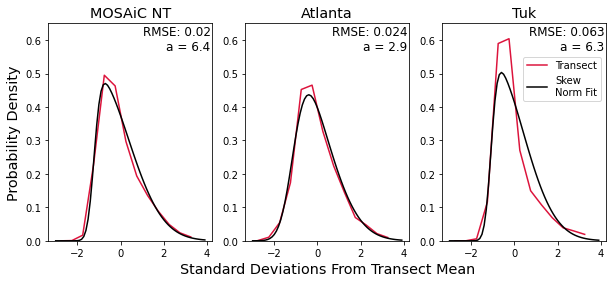

In [11]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,4))

bin_edges = np.arange(-3,4,0.5)
bin_centres = np.array([x+0.25 for x in bin_edges[:-1]])

fit_centres = np.arange(-3,4,0.1)

for name, ax in zip(['MOSAiC NT']+names,[ax1,ax2,ax3]):
    
    fit = skewnorm.fit(nas_arrays[name])
    
    print(fit)
    
    skew = skewnorm.pdf(fit_centres,
                       fit[0],
                       fit[1],
                       fit[2],
                          )

    skew_rmse = skewnorm.pdf(bin_centres,
                       fit[0],
                       fit[1],
                       fit[2],
                          )

    vals, be = np.histogram(nas_arrays[name],density=True,bins=bin_edges)

#     print(abs(skew_rmse - vals))
    rmse = np.round(np.sqrt(np.mean((skew_rmse - vals)**2)), decimals=3)
    
    ax.annotate(f'RMSE: {rmse}\na = {np.round(fit[0],decimals=1)}', ha = 'right', va = 'top',
                xy=(0.99,0.99), xycoords = 'axes fraction', fontsize='large')
        
#     print(np.sum(vals)*0.5)
    
    ax.plot(bin_centres,vals,color='crimson',label='Transect')
    
    ax.plot(fit_centres,skew,color='k',label='Skew\nNorm Fit')
    
    ax.set_title(name,fontsize='x-large')
    
    ax.set_ylim(0,0.65)
    
ax1.set_ylabel('Probability Density', fontsize='x-large')
ax2.set_xlabel('Standard Deviations From Transect Mean', fontsize='x-large')

ax3.legend(bbox_to_anchor=(1,0.87),loc='upper right')

plt.savefig(f'../figures/fig_10.png', bbox_inches='tight',dpi=500)
plt.savefig(f'/home/robbie/Dropbox/Apps/Overleaf/sub-km-snow-depth-dist/figs/fig10.png', bbox_inches='tight',dpi=500)
    
